# Waste heat recovery

## Objective: maximizing the recovered waste energy

### Connaissance a priori:

1 - "ELEC_TO_HEAT_RATIO" - Electricity-to-heat conversion ratio (0 to 1)


#### Thermal storage parameters (max 5MW)
 
2 - "PC_MAX_STORAGE" - The maximal charging and discharging powers

3 -  "PC_MIN_STORAGE" - The minimum charging and discharging powers

4 - "CAPA_STORAGE" - Storage capacity 

5 - "SOC_0_STORAGE" - Initial state of charge (0 to 1)


#### Heat pump parameters


6 - "COP" - The coefficient of performance . 

7 - "P_MAX_HP" - The heat pump has a electrical power limit

In [1]:
# *** OPTIMIZATION PARAMETERS *** 
# Par défaut:
# 90% of the electrical consumption is converted into heat
ELEC_TO_HEAT_RATIO = 0.9
# The maximal charging and discharging powers both equal 5 MW
PC_MAX_STORAGE = PD_MAX_STORAGE = 5000
# When charging/discharging, the power should at least be 20% of the maximal charging/discharging powers
PC_MIN_STORAGE = PD_MIN_STORAGE = 0.15 * PC_MAX_STORAGE
# Storage capacity of 20MWh
CAPA_STORAGE = 20000   
# Initial state of charge of 25%
SOC_0_STORAGE = 0.2
# The coefficient of performance equals 3
COP = 3           
# The heat pump has a electrical power limit of 1 MW
P_MAX_HP = 1000    

### Résultat:



In [2]:
%pylab notebook

Populating the interactive namespace from numpy and matplotlib


In [3]:
#! usr/bin/env python3
#  -*- coding: utf-8 -*-

"""
     ** This Module is an example of waste energy recovery **

    An electro-intensive industrial process consumes electricity and rejects
    heat. This waste energy is whether recovered or dissipated depending on
    the waste recovery system sizing. A storage system and a heat pump are
    used in order to recover the waste energy, which is then injected on a
    district heat network to provide heat to a district heat load. The
    missing heat will be provided by a district heat network production unit.

    The system includes :
     - An electro-intensive industry
     - A dissipation load
     - A thermal storage system
     - A heat pump
     - A district heat network load
     - A district heat network production unit

     The objective consists in maximizing the recovered waste energy
"""

from pulp import LpStatus
from omegalpes.energy.energy_nodes import EnergyNode
from omegalpes.energy.units.consumption_units import FixedConsumptionUnit, \
    VariableConsumptionUnit
from omegalpes.energy.units.conversion_units import \
    ElectricalToHeatConversionUnit, HeatPump
from omegalpes.energy.units.production_units import ProductionUnit
from omegalpes.energy.units.storage_units import StorageUnit
from omegalpes.general.optimisation.model import OptimisationModel
from omegalpes.general.time import TimeUnit
from omegalpes.general.plots import plot_quantity, plt, \
    plot_node_energetic_flows

In [5]:
def main(elec2heat_ratio=0.9, pc_max=5000, pd_max=5000, pc_min=1000,
         pd_min=1000, e_max=20000, cop_hp=3, pmax_elec_hp=1000,
         storage_soc_0=0.2):

    global time, indus, district_heat_load, heat_pump, heat_production, \
        heat_node_bef_valve, heat_node_aft_valve, \
        heat_node_aft_hp, thermal_storage, dissipation, model

    # OPTIMIZATION MODEL
    # Creating an empty model
    model = OptimisationModel(name='waste_e_recovery_model')

    # Creating the unit dedicated to time management
    time = TimeUnit(periods=24 * 7, dt=1)

    # Importing time-dependent data from files
    indus_cons_file = open("examples/data/indus_cons_week.txt", "r")
    heat_load_file = open("examples/data/District_heat_load_consumption.txt", "r")

    # Creating the electro-intensive industry unit
    indus_cons = [c for c in map(float, indus_cons_file)]
    indus = ElectricalToHeatConversionUnit(time, 'indus', pmax_in_heat=1,
                                           elec_to_heat_ratio=elec2heat_ratio,
                                           p_in_elec=indus_cons)

    # Creating unit for heat dissipation from the industrial process
    dissipation = VariableConsumptionUnit(time, 'dissipation',
                                          energy_type='Heat')

    # Creating the thermal storage
    thermal_storage = StorageUnit(time, 'thermal_storage', pc_max=pc_max,
                                  pd_max=pd_max, pc_min=pc_min, pd_min=pd_min,
                                  capacity=e_max, e_0=storage_soc_0 * e_max)

    # Creating the heat pump
    heat_pump = HeatPump(time, 'heat_pump', COP=cop_hp,
                         pmax_in_elec=pmax_elec_hp)

    # Creating the district heat load
    heat_load = [c for c in map(float, heat_load_file)]
    district_heat_load = FixedConsumptionUnit(time, 'district_heat_load',
                                              p=heat_load, energy_type='Heat')

    # Creating the heat production plants
    heat_production = ProductionUnit(time, name='heat_production',
                                     energy_type='Heat')

    # Creating the heat node for the energy flows
    heat_node_bef_valve = EnergyNode(time, 'heat_node_bef_valve',
                                     energy_type='Heat')
    heat_node_aft_valve = EnergyNode(time, 'heat_node_aft_valve',
                                     energy_type='Heat')
    heat_node_aft_hp = EnergyNode(time, 'heat_node_aft_hp', energy_type='Heat')
    
    # Connecting units to the nodes
    heat_node_bef_valve.connect_units(indus.heat_production_unit, dissipation)
    heat_node_bef_valve.export_to_node(
        heat_node_aft_valve)  # Export after the valve
    heat_node_aft_valve.connect_units(thermal_storage,
                                      heat_pump.heat_consumption_unit)

    heat_node_aft_hp.connect_units(heat_pump.heat_production_unit,
                                   heat_production, district_heat_load)

    # OBJECTIVE CREATION
    # Minimizing the part of the heat load covered by the heat production plant
    heat_production.minimize_production()

    # Adding all nodes (and connected units) to the optimization model
    model.add_nodes(heat_node_bef_valve, heat_node_aft_valve, heat_node_aft_hp)

    model.writeLP('waste_e_recovery.lp')   # Writing into lp file
    model.solve_and_update()  # Running optimization and update values

In [6]:
def print_results():
    """
        *** This function prints the optimisation result:
                - The district consumption during the year
                - The industry consumption during the year
                - The district heat network production during the year
                - The heat exported from the industry
                - The rate of the load covered by the industry

            And plots the power curves :
            On the first figure : the energy out of the industry with the
            recovered and the dissipated parts
            On the second figure: the energy on the district heating network
            with the part produced by the heat pump and
            the part produced by the district heating production unit.

    """

    # Print results
    if LpStatus[model.status] == 'Optimal':
        print("\n - - - - - OPTIMIZATION RESULTS - - - - - ")
        print('District consumption = {0} kWh.'.format(district_heat_load.e_tot))
        print('Industry consumption = {0} kWh.'.format(
            indus.elec_consumption_unit.e_tot))
        print('District heat network production = {0} kWh.'.format(
            heat_production.e_tot))
        print('Industry heat exported = {0} kWh.'.format(
            sum(
                heat_node_bef_valve.energy_export_to_heat_node_aft_valve
                    .value.values())))
        print('Heat pump electricity consumption = {0} kWh.'.format(
            heat_pump.elec_consumption_unit.e_tot))
        print("{0} % of the load coming from the industry".format(
            round(sum(list(
                heat_node_bef_valve.energy_export_to_heat_node_aft_valve
                    .value.values())) /
                  district_heat_load.e_tot.value * 100)))  # value is a dict,
        # with time as a key, and power levels as values.

        # SHOW THE GRAPH
        # Recovered and dissipated heat
        plot_node_energetic_flows(heat_node_bef_valve)

        # Energy on the recovery system
        plot_node_energetic_flows(heat_node_aft_valve)

        # Energy on the district heating network
        plot_node_energetic_flows(heat_node_aft_hp)

        plt.show()

    elif LpStatus[model.status] == 'Infeasible':
        print("Sorry, the optimisation problem has no feasible solution !")

    elif LpStatus[model.status] == 'Unbounded':
        print("The cost function of the optimisation problem is unbounded !")

    elif LpStatus[model.status] == 'Undefined':
        print("Sorry, a feasible solution has not been found (but may exist). "
              "PuLP does not manage to interpret the solver's output, "
              "the infeasibility of the MILP problem may have been "
              "detected during presolve")

    else:
        print("Sorry, the optimisation problem has not been solved.")

You are studying the period from 2018-01-01 00:00:00 to 2018-01-07 23:00:00
Creating the indus_heat_prod.
Creating the indus_heat_cons.
Creating the indus_elec_cons.
Creating the indus.
Creating the dissipation.
Creating the thermal_storage.
Creating the heat_pump_heat_prod.
Creating the heat_pump_heat_cons.
Creating the heat_pump_elec_cons.
Creating the heat_pump.
Creating the district_heat_load.
Creating the heat_production.
Creating the heat_node_bef_valve.
Creating the heat_node_aft_valve.
Creating the heat_node_aft_hp.

--- Adding all variables to the model ---
Adding variable : heat_node_bef_valve_energy_export_to_heat_node_aft_valve
Adding variable : heat_node_bef_valve_is_exporting_to_heat_node_aft_valve
Adding variable : indus_heat_prod_p
Adding variable : indus_heat_prod_e_tot
Adding variable : indus_heat_prod_u
Adding variable : dissipation_p
Adding variable : dissipation_e_tot
Adding variable : dissipation_u
Adding variable : indus_heat_cons_p
Adding variable : indus_heat_c

C:\ENIGMa\omegalpes\general\optimisation\model.py:324: UserWarning: The unit indus seems to have as parent indus_heat_prod which was not declared as parent.
  parent_name))
C:\ENIGMa\omegalpes\general\optimisation\model.py:324: UserWarning: The unit indus seems to have as parent indus_heat_cons which was not declared as parent.
  parent_name))
C:\ENIGMa\omegalpes\general\optimisation\model.py:324: UserWarning: The unit indus seems to have as parent indus_elec_cons which was not declared as parent.
  parent_name))
C:\ENIGMa\omegalpes\general\optimisation\model.py:324: UserWarning: The unit heat_pump seems to have as parent heat_pump_heat_prod which was not declared as parent.
  parent_name))
C:\ENIGMa\omegalpes\general\optimisation\model.py:324: UserWarning: The unit heat_pump seems to have as parent heat_pump_heat_cons which was not declared as parent.
  parent_name))
C:\ENIGMa\omegalpes\general\optimisation\model.py:324: UserWarning: The unit heat_pump seems to have as parent heat_pum

Adding constraint : heat_pump_elec_cons_calc_e_tot , exp = heat_pump_elec_cons_e_tot == time.DT * lpSum(heat_pump_elec_cons_p[t] for t in time.I)
Adding constraint : heat_node_aft_hp_power_balance , exp = heat_pump_heat_prod_p[t]+heat_production_p[t]-district_heat_load_p[t] == 0 for t in time.I
Adding constraint : heat_production_on_off_max , exp = heat_production_p[t] <= heat_production_u[t] * 100000.0 for t in time.I
Adding constraint : heat_production_on_off_min , exp = heat_production_p[t] >= heat_production_u[t] * 1e-05 for t in time.I
Adding constraint : heat_production_calc_e_tot , exp = heat_production_e_tot == time.DT * lpSum(heat_production_p[t] for t in time.I)
Adding constraint : district_heat_load_on_off_max , exp = district_heat_load_p[t] <= district_heat_load_u[t] * 100000.0 for t in time.I
Adding constraint : district_heat_load_on_off_min , exp = district_heat_load_p[t] >= district_heat_load_u[t] * 1e-05 for t in time.I
Adding constraint : district_heat_load_calc_e_tot 

<IPython.core.display.Javascript object>


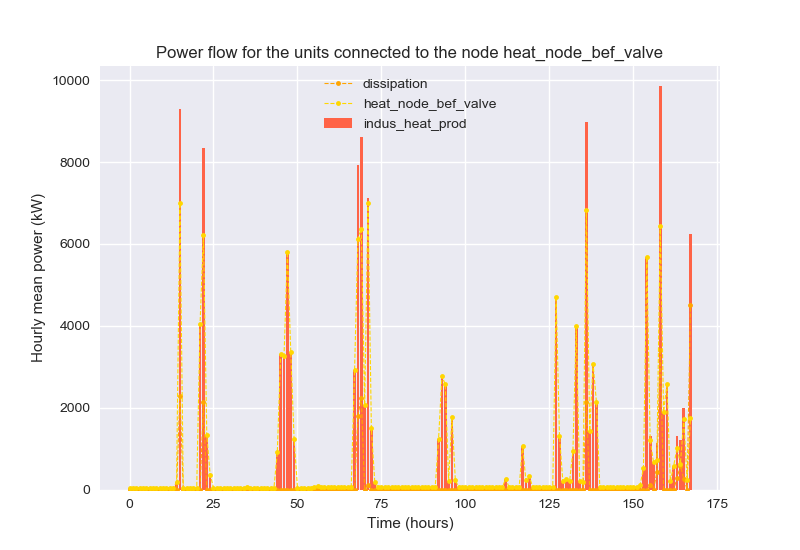


Preparing to plot the energetic flows through the node heat_node_bef_valve.
	Add power from indus_heat_prod.
	Add power from dissipation.
	Add power from heat_node_bef_valve.


<IPython.core.display.Javascript object>


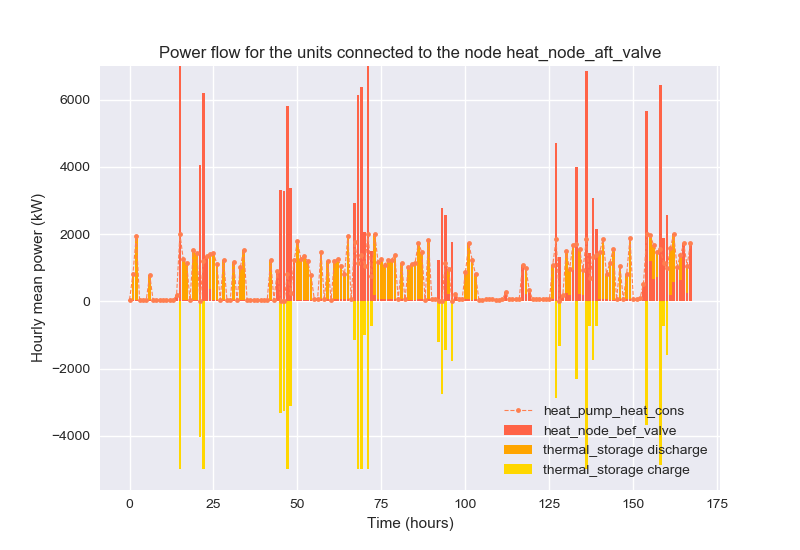


Preparing to plot the energetic flows through the node heat_node_aft_valve.
	Add power from heat_node_bef_valve.
	Add power from thermal_storage.
	Add power from heat_pump_heat_cons.


<IPython.core.display.Javascript object>


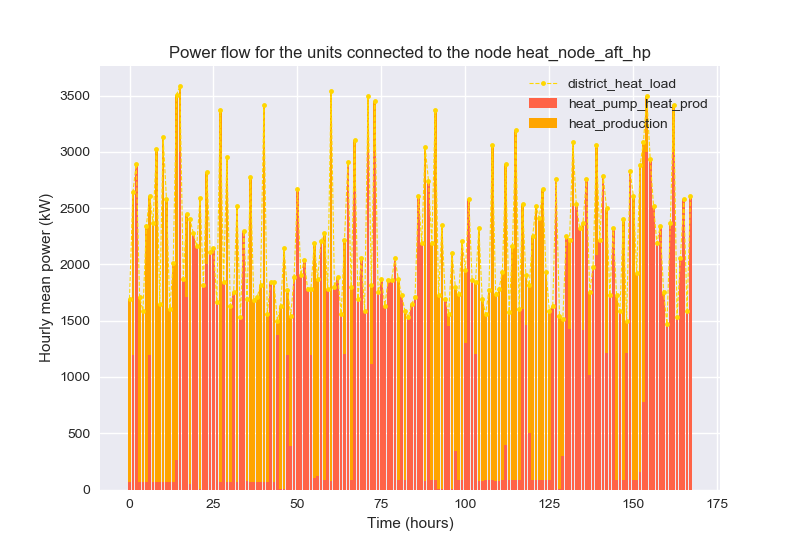


Preparing to plot the energetic flows through the node heat_node_aft_hp.
	Add power from heat_pump_heat_prod.
	Add power from heat_production.
	Add power from district_heat_load.


In [7]:
# *** OPTIMIZATION PARAMETERS *** #

    # --- Electricity-to-Heat conversion ---
    # 90% of the electrical consumption is converted into heat
ELEC_TO_HEAT_RATIO = 0.9

    # --- Thermal storage parameters ---
    # The maximal charging and discharging powers both equal 5 MW
PC_MAX_STORAGE = PD_MAX_STORAGE = 5000

    # When charging/discharging, the power should at least be 20% of the
    # maximal charging/discharging powers
PC_MIN_STORAGE = PD_MIN_STORAGE = 0.15 * PC_MAX_STORAGE

CAPA_STORAGE = 20000    # Storage capacity of 20MWh
SOC_0_STORAGE = 0.2    # Initial state of charge of 25%

    # --- Heat pump parameters ---
COP = 3            # The coefficient of performance equals 3
P_MAX_HP = 1000    # The heat pump has a electrical power limit of 1 MW

    # *** RUN MAIN ***
main(elec2heat_ratio=ELEC_TO_HEAT_RATIO, pc_max=PC_MAX_STORAGE,
         pd_max=PD_MAX_STORAGE, pc_min=PC_MIN_STORAGE,
         pd_min=PD_MIN_STORAGE, e_max=CAPA_STORAGE, cop_hp=COP,
         pmax_elec_hp=P_MAX_HP, storage_soc_0=SOC_0_STORAGE)

    # *** SHOW THE RESULTS ***
print_results()